## Imports

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spectral.io.envi as envi
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import load_digits
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, GridSearchCV
# from yellowbrick.model_selection import RFECV
from time import time
# from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils import shuffle


# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.models import Sequential
# from keras.layers import Dense

# print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pip install joypy

In [ ]:
import joypy

## Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## learning curve based on number of samples

#### Load Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')
# dataset.head(3)
columns = dataset.iloc[:, 2:].columns.values

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/X.npy')
y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/y.npy')

In [ ]:
X = X[::10, :]
y = y[::10]
X.shape

(84101, 186)

In [ ]:
df = pd.DataFrame(data=X, columns=columns)

In [ ]:
df.head(2)

,Band_001,Band_002,Band_003,Band_004,Band_005,Band_006,Band_007,Band_008,Band_009,Band_010,Band_011,Band_012,Band_013,Band_014,Band_015,Band_016,Band_017,Band_018,Band_019,Band_020,Band_021,Band_022,Band_023,Band_024,Band_025,Band_026,Band_027,Band_028,Band_029,Band_030,Band_031,Band_032,Band_033,Band_034,Band_035,Band_036,Band_037,Band_038,Band_039,Band_040,...,Band_147,Band_148,Band_149,Band_150,Band_151,Band_152,Band_153,Band_154,Band_155,Band_156,Band_157,Band_158,Band_159,Band_160,Band_161,Band_162,Band_163,Band_164,Band_165,Band_166,Band_167,Band_168,Band_169,Band_170,Band_171,Band_172,Band_173,Band_174,Band_175,Band_176,Band_177,Band_178,Band_179,Band_180,Band_181,Band_182,Band_183,Band_184,Band_185,Band_186
0,0.055364,0.071277,0.062560,0.062931,0.073905,0.055737,0.062921,0.060123,0.056552,0.062749,0.059414,0.059066,0.066134,0.064663,0.062497,0.063313,0.062573,0.063923,0.072067,0.061628,0.068952,0.069534,0.063854,0.063532,0.063523,0.063333,0.066438,0.065995,0.068486,0.067091,0.065591,0.069869,0.071611,0.071547,0.075075,0.079294,0.077710,0.074765,0.081016,0.080989,...,0.256003,0.244539,0.252226,0.255288,0.258960,0.255068,0.257223,0.266414,0.260323,0.269098,0.268707,0.262175,0.269845,0.263428,0.276127,0.277523,0.279097,0.271806,0.286093,0.284609,0.276917,0.290901,0.271737,0.296084,0.287388,0.288105,0.297305,0.287817,0.293130,0.280577,0.294222,0.307158,0.299976,0.291312,0.304959,0.295205,0.289494,0.300307,0.298140,0.306262
1,0.074993,0.072435,0.064133,0.080734,0.088216,0.070953,0.067431,0.068336,0.079696,0.081326,0.072144,0.064534,0.071140,0.076132,0.076926,0.073100,0.068827,0.075382,0.074642,0.074307,0.076571,0.078271,0.073199,0.074093,0.081167,0.073853,0.073868,0.075267,0.083201,0.082551,0.086952,0.093180,0.105580,0.112416,0.123468,0.129664,0.151454,0.161905,0.169379,0.175393,...,0.505026,0.494720,0.483715,0.488838,0.488722,0.487259,0.482478,0.480058,0.500768,0.489220,0.471241,0.482861,0.477204,0.484921,0.481572,0.477932,0.482379,0.469481,0.480970,0.455296,0.474330,0.453260,0.479589,0.466238,0.457954,0.463635,0.447302,0.468616,0.465824,0.460319,0.453349,0.457308,0.448119,0.459175,0.454227,0.460216,0.452923,0.471841,0.476259,0.469941


In [ ]:
df.insert(loc=0, column="Label", value=y)

In [ ]:
pos_class_dataset = df[y==1]
neg_class_dataset = df[y==0]

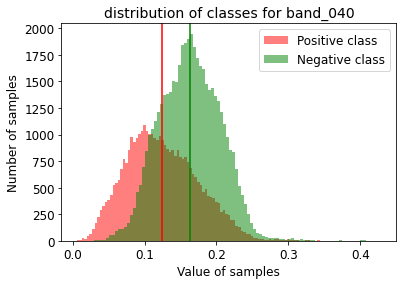

In [ ]:
Band_no = 40

pos_class = pos_class_dataset.iloc[:, Band_no:Band_no+1].values
neg_class = neg_class_dataset.iloc[:, Band_no:Band_no+1].values

# t_statistic, p_value = stats.ttest_ind(pos_class, neg_class)

# plt.figure(figsize=(17, 5))
plt.hist(pos_class, label='Positive class', bins=100, alpha=0.5, color='r')
plt.hist(neg_class, label='Negative class', bins=100, alpha=0.5, color='g')
plt.axvline(x=np.mean(pos_class_dataset.iloc[:, Band_no:Band_no+1].values), color='r')
plt.axvline(x=np.mean(neg_class_dataset.iloc[:, Band_no:Band_no+1].values), color='g')
plt.xlabel('Value of samples', fontsize=12)
plt.ylabel('Number of samples', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('distribution of classes for band_0' + str(Band_no) , fontsize=14)
plt.legend(loc='best', fontsize=12)
# plt.savefig('/content/drive/MyDrive/Thesis/images/unnormalized/t_test/class_dist_band_46.png')
plt.show()

In [ ]:
pos_mean = pos_class_dataset.mean()
neg_mean = neg_class_dataset.mean()
pos_std = pos_class_dataset.std()
neg_std = neg_class_dataset.std()

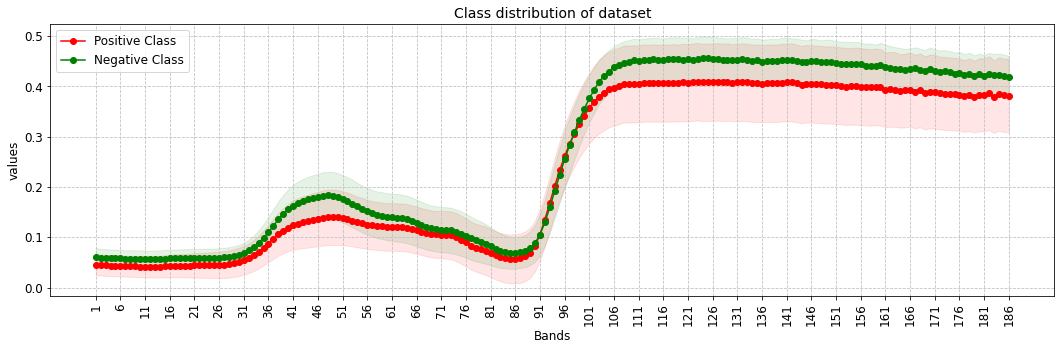

In [ ]:
plt.figure(figsize=(18, 5))
steps = np.arange(186) + 1
plt.fill_between(steps, pos_mean - pos_std,
                 pos_mean + pos_std, alpha=0.1, color="r")
plt.fill_between(steps, neg_mean - neg_std,
                 neg_mean + neg_std, alpha=0.1, color="g")
plt.plot(steps, pos_mean, 'o-', color="r", label="Positive Class")
plt.plot(steps, neg_mean, 'o-', color="g", label="Negative Class")
# plt.axvline(x=val_scores_mean_arr.argmax() + 1, ls='--', label='n_features = {}, Score = {}'.format                             (val_scores_mean_arr.argmax()+1, round(val_scores_mean_arr.max(), 2)))
plt.xlabel("Bands", fontsize=12)
plt.ylabel("values", fontsize=12)
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Class distribution of dataset", fontsize=14)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best", fontsize=12)
plt.show()

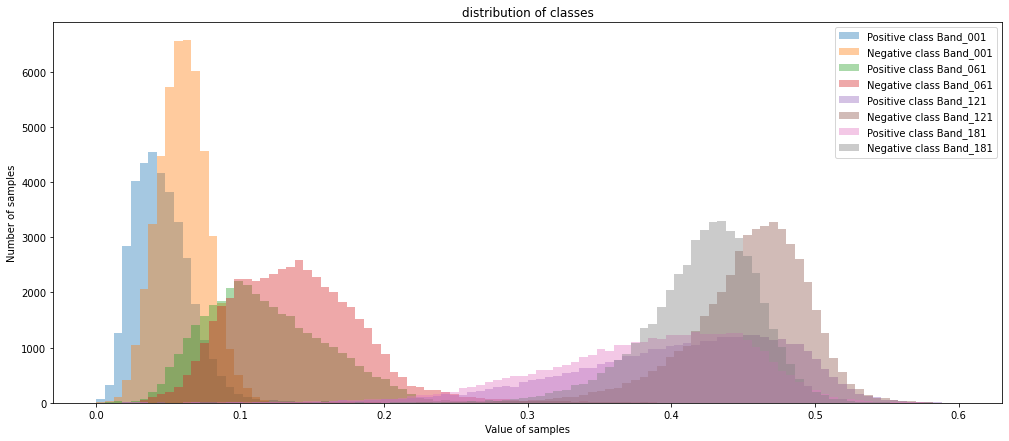

In [ ]:
plt.figure(figsize=(17, 7))
for im in range(0, 186, 60):
    # load channel 45 for sanity check
    band = df.iloc[:, im:im+1].values
    # filter values of classes based on index
    pos_class = band[y==1]
    neg_class = band[y==0]

    # t_statistic, p_value = stats.ttest_ind(pos_class, neg_class)

    plt.hist(pos_class, label='Positive class ' + df.columns[im:im+1], bins=100, alpha=0.4, range=[0, 0.6])
    plt.hist(neg_class, label='Negative class ' + df.columns[im:im+1], bins=100, alpha=0.4, range=[0, 0.6])
    plt.xlabel('Value of samples')
    plt.ylabel('Number of samples')
    plt.title('distribution of classes')
    plt.legend(loc='upper right')
    # plt.savefig('../../Images/plots/dist_features_classwise/t_test__sanity_check/all' + '.png')
    plt.show

In [ ]:
tf = df.transpose()

In [ ]:
pos_class_dataset = df[y==1]
neg_class_dataset = df[y==0]

In [ ]:
pos_class_dataset.shape

(36431, 186)

In [ ]:
neg_class_dataset.shape

(47670, 186)

In [ ]:
neg_class_dataset.shape[0] - pos_class_dataset.shape[0]

11239

In [ ]:
a = np.empty((11239, 186,))
a.fill(np.nan)

In [ ]:
a.shape

(11239, 186)

In [ ]:
c = pd.DataFrame(data=a, columns=df.columns.values)

In [ ]:
pos_class_dataset = pos_class_dataset.append(c)
pos_class_dataset

,Band_001,Band_002,Band_003,Band_004,Band_005,Band_006,Band_007,Band_008,Band_009,Band_010,Band_011,Band_012,Band_013,Band_014,Band_015,Band_016,Band_017,Band_018,Band_019,Band_020,Band_021,Band_022,Band_023,Band_024,Band_025,Band_026,Band_027,Band_028,Band_029,Band_030,Band_031,Band_032,Band_033,Band_034,Band_035,Band_036,Band_037,Band_038,Band_039,Band_040,...,Band_147,Band_148,Band_149,Band_150,Band_151,Band_152,Band_153,Band_154,Band_155,Band_156,Band_157,Band_158,Band_159,Band_160,Band_161,Band_162,Band_163,Band_164,Band_165,Band_166,Band_167,Band_168,Band_169,Band_170,Band_171,Band_172,Band_173,Band_174,Band_175,Band_176,Band_177,Band_178,Band_179,Band_180,Band_181,Band_182,Band_183,Band_184,Band_185,Band_186
0,0.055364,0.071277,0.062560,0.062931,0.073905,0.055737,0.062921,0.060123,0.056552,0.062749,0.059414,0.059066,0.066134,0.064663,0.062497,0.063313,0.062573,0.063923,0.072067,0.061628,0.068952,0.069534,0.063854,0.063532,0.063523,0.063333,0.066438,0.065995,0.068486,0.067091,0.065591,0.069869,0.071611,0.071547,0.075075,0.079294,0.077710,0.074765,0.081016,0.080989,...,0.256003,0.244539,0.252226,0.255288,0.258960,0.255068,0.257223,0.266414,0.260323,0.269098,0.268707,0.262175,0.269845,0.263428,0.276127,0.277523,0.279097,0.271806,0.286093,0.284609,0.276917,0.290901,0.271737,0.296084,0.287388,0.288105,0.297305,0.287817,0.293130,0.280577,0.294222,0.307158,0.299976,0.291312,0.304959,0.295205,0.289494,0.300307,0.298140,0.306262
1,0.074993,0.072435,0.064133,0.080734,0.088216,0.070953,0.067431,0.068336,0.079696,0.081326,0.072144,0.064534,0.071140,0.076132,0.076926,0.073100,0.068827,0.075382,0.074642,0.074307,0.076571,0.078271,0.073199,0.074093,0.081167,0.073853,0.073868,0.075267,0.083201,0.082551,0.086952,0.093180,0.105580,0.112416,0.123468,0.129664,0.151454,0.161905,0.169379,0.175393,...,0.505026,0.494720,0.483715,0.488838,0.488722,0.487259,0.482478,0.480058,0.500768,0.489220,0.471241,0.482861,0.477204,0.484921,0.481572,0.477932,0.482379,0.469481,0.480970,0.455296,0.474330,0.453260,0.479589,0.466238,0.457954,0.463635,0.447302,0.468616,0.465824,0.460319,0.453349,0.457308,0.448119,0.459175,0.454227,0.460216,0.452923,0.471841,0.476259,0.469941
2,0.045479,0.042046,0.037275,0.043536,0.034465,0.042052,0.041346,0.036096,0.037316,0.034090,0.038630,0.037338,0.038530,0.039467,0.037237,0.036758,0.041296,0.038946,0.038131,0.033877,0.036581,0.036654,0.043430,0.040508,0.038260,0.039300,0.039091,0.035584,0.043376,0.038516,0.041190,0.044052,0.045166,0.049253,0.055280,0.056265,0.060899,0.063739,0.068785,0.068890,...,0.180802,0.178378,0.176781,0.181192,0.180998,0.177616,0.173728,0.184667,0.180696,0.179134,0.180556,0.175598,0.176941,0.179723,0.179929,0.182357,0.179584,0.178325,0.181278,0.178470,0.181702,0.175787,0.171325,0.178576,0.181164,0.177727,0.170604,0.175006,0.180909,0.169396,0.169240,0.168891,0.165199,0.170660,0.173753,0.182452,0.168766,0.164232,0.174707,0.171867
3,0.059362,0.073691,0.067188,0.061858,0.060211,0.075551,0.063941,0.074498,0.076050,0.070850,0.068087,0.062289,0.071001,0.068950,0.072138,0.070238,0.071090,0.067059,0.071878,0.069903,0.071229,0.067721,0.068790,0.071841,0.068223,0.073388,0.070081,0.071014,0.072091,0.074632,0.076805,0.080509,0.085880,0.098362,0.111718,0.122858,0.138073,0.147117,0.162439,0.171759,...,0.490030,0.488391,0.483951,0.488492,0.489625,0.482018,0.487435,0.483758,0.489945,0.484321,0.487328,0.470915,0.488713,0.469210,0.475121,0.471969,0.478390,0.475448,0.487236,0.454194,0.453185,0.473543,0.471129,0.454084,0.464824,0.464682,0.465379,0.462751,0.452313,0.451746,0.450643,0.443694,0.450258,0.460392,0.439755,0.462743,0.454619,0.467870,0.471798,0.457274
4,0.045707,0.028661,0.030899,0.030118,0.028120,0.025372,0.026117,0.026390,0.022691,0.023506,0.023315,0.027190,0.027847,0.028724,0.028376,0.025277,0.024465,0.023279,0.026951,0.025766,0.023456,0.024510,0.023943,0.024770,0.025864,0.025310,0.026585,0.027528,0.028702,0.031151,0.032195,0.033409,0.039152,0.042574,0.046095,0.051096,0.055987,0.062250,0.065161,0.068740,...,0.231

In [ ]:
pos = np.array(pos_class_dataset.values)
neg = np.array(neg_class_dataset.values)

In [ ]:
pos = pos.transpose()
pos = pos.flatten()

neg = neg.transpose()
neg = neg.flatten()

In [ ]:
cf = pd.DataFrame(data=pos, columns=['Positive_Class'])

In [ ]:
cf.insert(loc=1, column='Negative_Class', value=neg)

In [ ]:
cf.head()

,Positive_Class,Negative_Class
0,0.055364,0.056591
1,0.074993,0.074222
2,0.045479,0.041023
3,0.059362,0.076380
4,0.045707,0.077178


In [ ]:
bands = df.columns.values.reshape((-1, 1))

In [ ]:
label = pd.DataFrame(data=bands)

In [ ]:
for i in range(1, 47670):
  label.insert(loc=i, value=bands, column=i)

In [ ]:
label.shape

(186, 47670)

In [ ]:
label_arr = label.values.flatten()

In [ ]:
cf.insert(loc=2, column='Band', value=label_arr)

In [ ]:
cf

,Positive_Class,Negative_Class,Band
0,0.055364,0.056591,Band_001
1,0.074993,0.074222,Band_001
2,0.045479,0.041023,Band_001
3,0.059362,0.076380,Band_001
4,0.045707,0.077178,Band_001
...,...,...,...
8866615,NaN,0.287127,Band_186
8866616,NaN,0.369903,Band_186
8866617,NaN,0.394309,Band_186
8866618,NaN,0.462341,Band_186


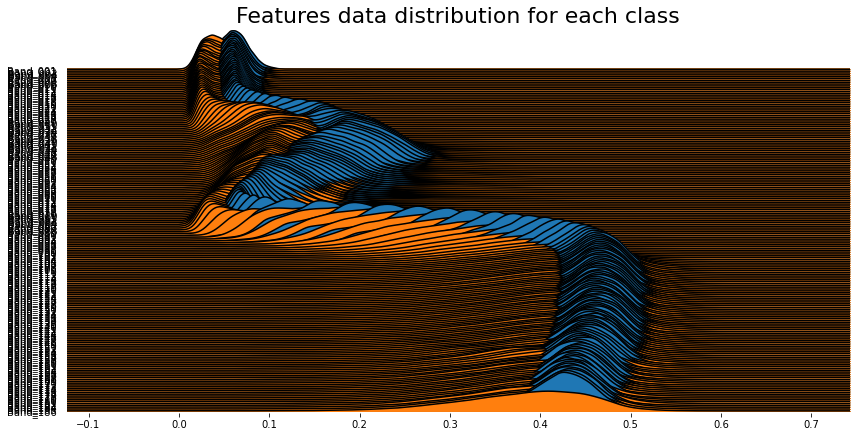

In [ ]:
fig, axes = joypy.joyplot(cf, column=['Negative_Class', 'Positive_Class'], by="Band", ylim='own', figsize=(12,6))

# Decoration
plt.title('Features data distribution for each class', fontsize=22)
plt.show()

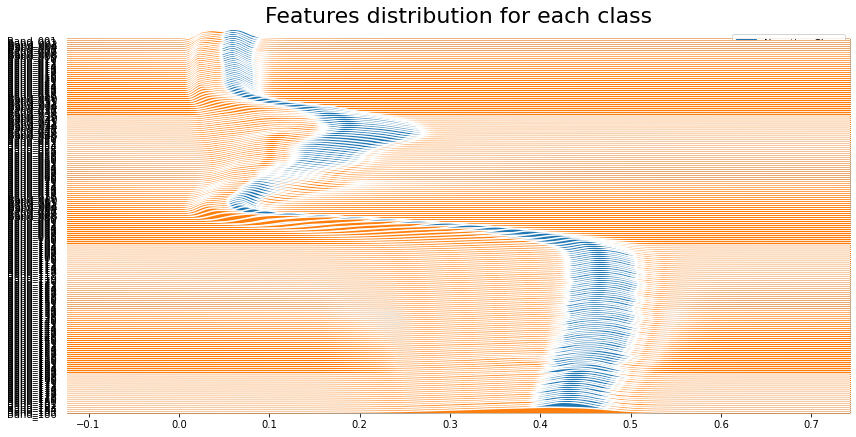

In [ ]:
fig, axes = joypy.joyplot(cf, column=['Negative_Class', 'Positive_Class'], 
                          by="Band", 
                          ylim='own', 
                          # linewidth=0.,
                          linecolor="w",
                          legend=True,
                          figsize=(12,6))

# Decoration
plt.title('Features distribution for each class', fontsize=22)
plt.show()

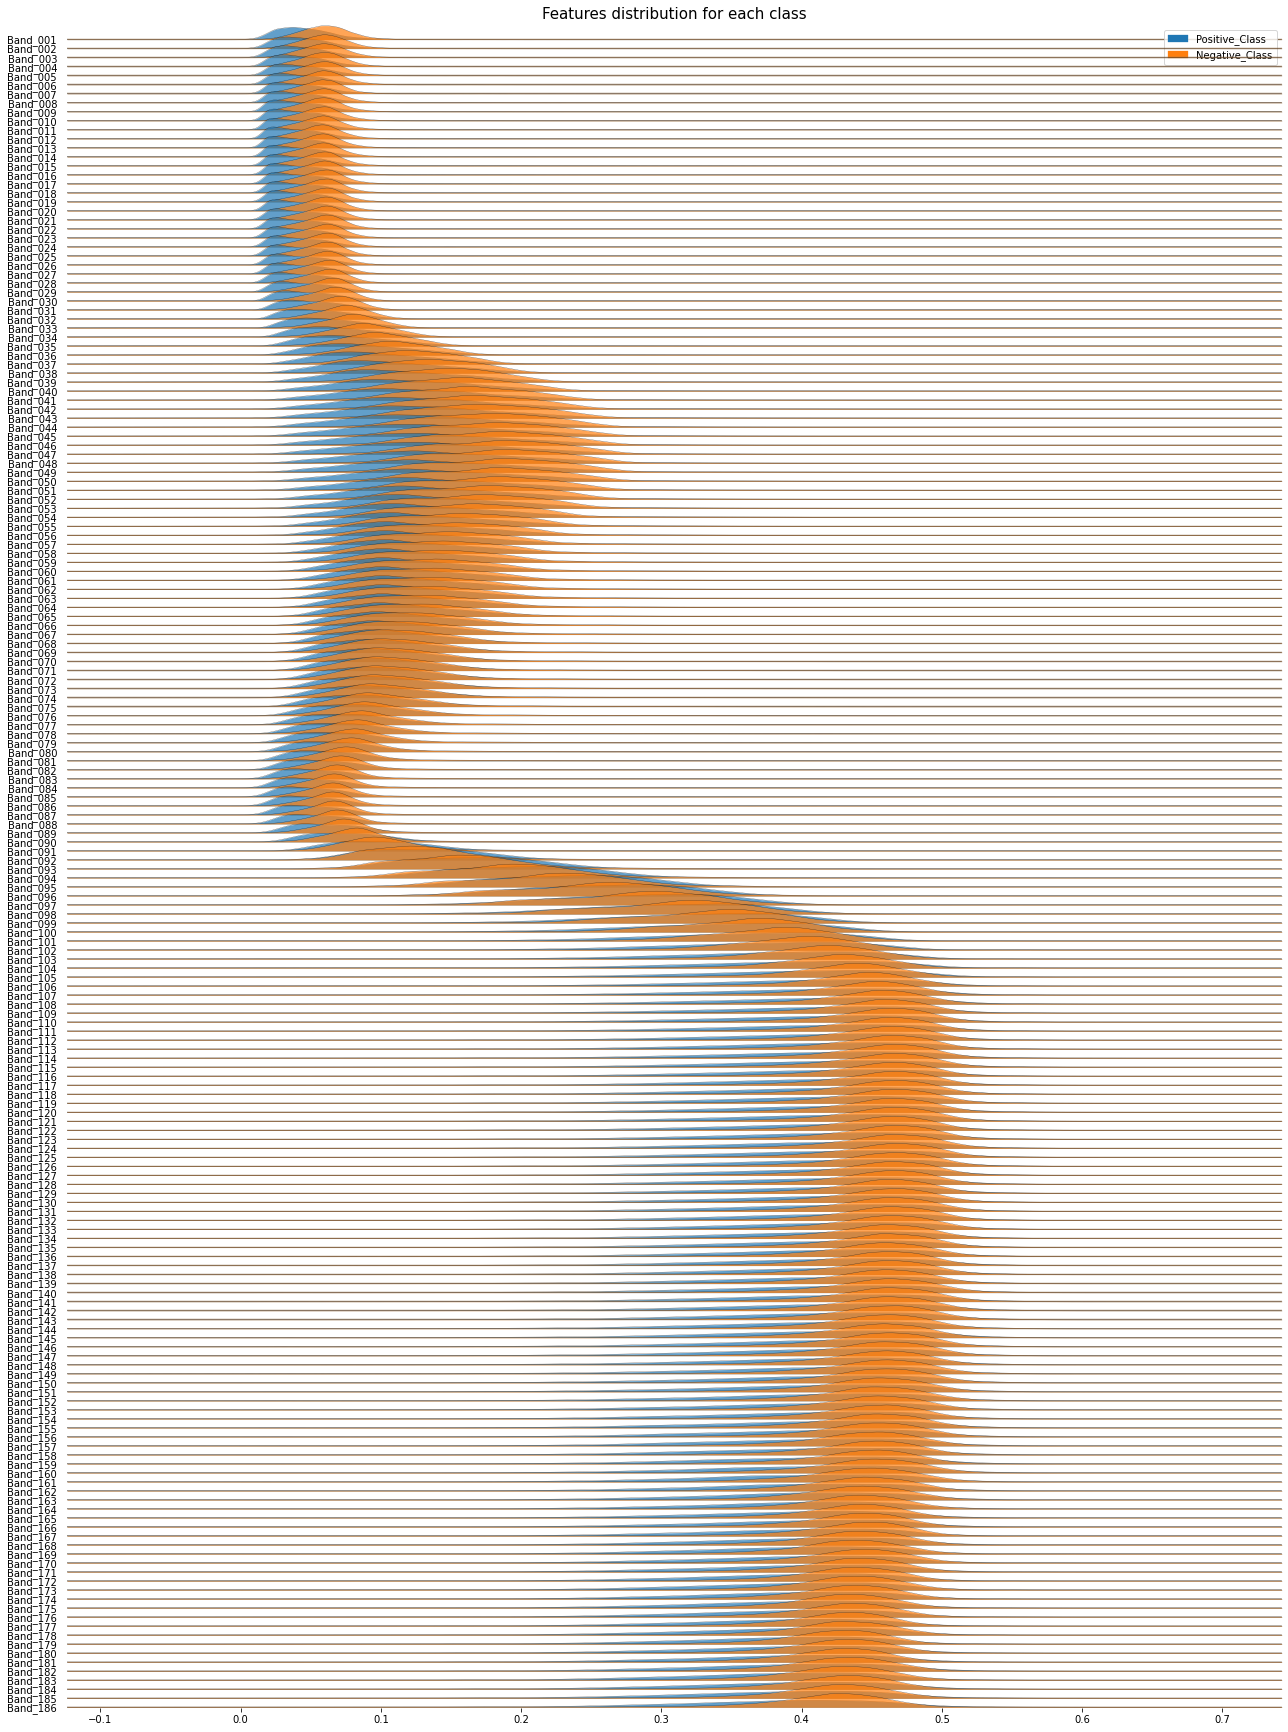

In [ ]:
fig, axes = joypy.joyplot(cf, column=['Negative_Class', 'Positive_Class'], 
                          by="Band", 
                          ylim='own', 
                          linewidth=0.3,
                          legend=True, 
                          alpha=0.7,
                          # overlap=.8,
                          figsize=(12,6))

# Decoration
plt.title('Features distribution for each class', fontsize=15)
plt.show()

In [ ]:
fig, axes = joypy.joyplot(cf, 
                          column=['Negative_Class', 'Positive_Class'], 
                          by="Band", 
                          ylim='own', 
                          alpha=0.7,
                          overlap=0,
                          # linewidth=0.4,
                          linewidth=0.,
                          linecolor="w",
                          # background='black'
                          legend=True, 
                          colormap=cm.autumn_r,
                          figsize=(18,10))

# Decoration
plt.title('Features distribution for each class', fontsize=15)
plt.xlabel('values', fontsize=14, color='grey', alpha=1)
plt.ylabel('Bands', fontsize=8, color='grey', alpha=1)
plt.show()

In [ ]:
# restart runtime and clear ram
import os, signal
os.kill(os.getpid(), signal.SIGKILL)